## Introduction

This notebook will document a small NLP project on classifying News articles into 31 different categories, from Politics, to Sport, to Religion etc. The source of news headlines and short descriptions is HuffPost and the dataset was downloaded from: https://www.kaggle.com/rmisra/news-category-dataset/downloads/news-category-dataset.zip/2. I will use pre-processing techniques such as tokenisation, stemming and stopword removal, and in regard to modelling, I will use bag of words, TF-IDF and Word2Vec/GloVe to build features. I will use SVM and Naive Bayes to build the supervised learning model on those features.

In [208]:
import nltk
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib as plt



## Exploratory Analysis and Data Cleaning

In [209]:
df = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [210]:
# Over 200k news articles
df.shape

(200853, 6)

How many categories and how many articles in each category are there in the dataset?

In [211]:
print('Number of Categories',df.groupby('category').ngroups)

Number of Categories 41


In [212]:
df.groupby('category').size().sort_values(ascending=False)

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
dtype: 

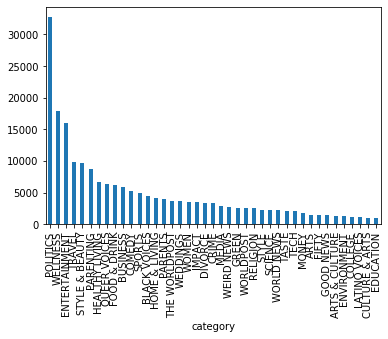

In [213]:
df.groupby('category').size().sort_values(ascending=False).plot.bar()

We can see there's alot of small categories, so lets see if we can group up similar categories and see if its better. For example:
- Parenting vs Parents
- Arts & Culture vs Culture & Arts vs Arts
- Education vs College
- Environment vs Green
- Style vs Style & beauty

In [214]:
df['category'] = np.where(df['category'] == 'PARENTS', 'PARENTING', df['category'])
df['category'] = np.where(df['category'].str.contains('ARTS'), 'ARTS', df['category'])
df['category'] = np.where(df['category'] == "COLLEGE", 'EDUCATION', df['category'])
df['category'] = np.where(df['category'] == "GREEN", 'ENVIRONMENT', df['category'])
df['category'] = np.where(df['category'] == "STYLE", 'STYLE & BEAUTY', df['category'])
df['category'] = np.where(df['category'] == "TASTE", 'FOOD & DRINK', df['category'])
df['category'] = np.where(df['category'].str.contains("WORLDPOST"), 'WORLD NEWS', df['category'])


In [215]:
df.groupby('category').size().sort_values(ascending=False)

category
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
PARENTING         12632
STYLE & BEAUTY    11903
TRAVEL             9887
WORLD NEWS         8420
FOOD & DRINK       8322
HEALTHY LIVING     6694
QUEER VOICES       6314
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
ENVIRONMENT        3945
ARTS               3878
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
RELIGION           2556
SCIENCE            2178
EDUCATION          2148
TECH               2082
MONEY              1707
FIFTY              1401
GOOD NEWS          1398
LATINO VOICES      1129
dtype: int64

Reduced down to 32 categories. Might be hard to classify the rarer categories, but we'll try for now. We might just try the 10 categories with most articles

In [216]:
categories = df.groupby('category').size().sort_values(ascending=False).reset_index(name='count')
df = df[ df['category'].isin(categories.iloc[:10,0])]

In [217]:
set(df['category'])

{'ENTERTAINMENT',
 'FOOD & DRINK',
 'HEALTHY LIVING',
 'PARENTING',
 'POLITICS',
 'QUEER VOICES',
 'STYLE & BEAUTY',
 'TRAVEL',
 'WELLNESS',
 'WORLD NEWS'}

Lets join the headline with the description, separated by a space, since both of them will contain useful information.

In [218]:
df['fulltext'] = df['headline'] + ' ' + df['short_description']

In [219]:
df.iloc[0,-1]

"Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song."

Create column for number of words in each text

In [220]:
df['count_words'] = df['fulltext'].str.split().str.len()

How do number of words vary by category? What is the mean number of words for each category?
- there doesn't seem to be a huge variation in number of words in each text for different categories
- 'FIFTY' seems a bit of an outlier?

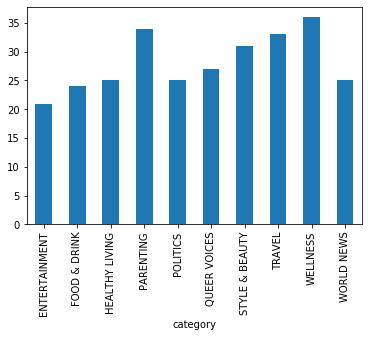

In [114]:
df[['category','count_words']].groupby('category')['count_words'].median().plot.bar(y='count_words')

## Data Processing
- Data processing involves doing:
    - tokenisation
    - stemming or lemmatization
    - removing stop words
    - removing numeric text and punctation
    - remove blanks and convert to lowercase
- Instead of NLTK, I might use scikit learn's automatic processing methods, which does it all automatically out of the box

In [223]:
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn import preprocessing

In [116]:
# Convert to Lowercase
df['fulltext_processed'] = df['fulltext'].str.lower()

# Tokenise words
df["tokens"] = df["fulltext_processed"].apply(word_tokenize)

# df['fulltext_processed'][0]


In [117]:
# Stopwords
stop_words = set(stopwords.words('english'))
# tokens = [w for w in sentence for sentence in df["tokens"] if not w in stop_words]
text_nostopwords = []
for sentence in df["fulltext_processed"]:
    removed_sent = ' '.join([word for word in sentence.split() if word not in stop_words])
    text_nostopwords.append(removed_sent)

text_nostopwords
# Note this is already done in the sklearn countvectoriser

["smith joins diplo nicky jam 2018 world cup's official song course song.",
 'hugh grant marries first time age 57 actor longtime girlfriend anna eberstein tied knot civil ceremony.',
 "jim carrey blasts 'castrato' adam schiff democrats new artwork actor gives dems ass-kicking fighting hard enough donald trump.",
 'julianna margulies uses donald trump poop bags pick dog "dietland" actress said using bags "really cathartic, therapeutic moment."',
 'morgan freeman \'devastated\' sexual harassment claims could undermine legacy "it right equate horrific incidents sexual assault misplaced compliments humor," said statement.',
 "donald trump lovin' new mcdonald's jingle 'tonight show' bit catchy, right.",
 "watch amazon prime that’s new week there's great mini-series joining week.",
 'mike myers reveals he\'d \'like to\' fourth austin powers film myer\'s kids may pushing new "powers" film anyone.',
 'watch hulu that’s new week getting recent academy award-winning movie.',
 'justin timberlake

## Train Test Split

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df['fulltext_processed'], df['category'], test_size=0.2, random_state=0)

In [119]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_train)
test_y = encoder.fit_transform(y_test)

## Bag of Words

In [120]:
# Maximum 1500 features and the words must have appeared in at least 10 texts
vectorizer1 = CountVectorizer(max_features=1500,min_df=5,max_df=0.7, stop_words=stopwords.words('english'))
X_train_counts = vectorizer1.fit_transform(X_train)

X_test_counts = vectorizer1.transform(X_test)


In [121]:
print(vectorizer1.get_feature_names())

['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '2012', '2013', '2014', '2015', '2016', '2017', '21', '24', '25', '30', '40', '50', 'ability', 'able', 'abortion', 'absolutely', 'abuse', 'accept', 'access', 'according', 'accused', 'across', 'act', 'action', 'actions', 'activists', 'actor', 'actress', 'actually', 'ad', 'add', 'addiction', 'address', 'administration', 'adorable', 'adult', 'adults', 'advice', 'affordable', 'afraid', 'africa', 'age', 'agency', 'ago', 'agree', 'ahead', 'air', 'airlines', 'airport', 'al', 'album', 'allegations', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'amazing', 'america', 'american', 'americans', 'amid', 'among', 'anniversary', 'announced', 'annual', 'another', 'answer', 'anti', 'anxiety', 'anyone', 'anything', 'apparently', 'appears', 'approach', 'april', 'area', 'around', 'art', 'article', 'artist', 'ask', 'asked', 'asking', 'assault', 'attack', 'attacks', 'attention', 'attorney', 'auth

In [122]:
print(X_train_counts.shape)
print(X_test_counts.shape)

(104636, 1500)
(26160, 1500)


In [123]:
# For each article we have 3000 columns, a count for each word
print(X_train_counts.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [124]:
classifier = MultinomialNB().fit(X_train_counts, train_y)
y_pred = classifier.predict(X_test_counts)


In [125]:
print('confusion matrix:',confusion_matrix(test_y,y_pred))
print('classification report:', classification_report(test_y,y_pred))
print('accuracy:',accuracy_score(test_y, y_pred))

confusion matrix: [[2082   68   14  171  369   53  194   92  122   44]
 [  69 1136    8   51   46    5   61  128  129    8]
 [  48   62  177  112  102   18   17   50  779   17]
 [ 127   54   50 1835   45   34   52   68  184   16]
 [ 226   23   78  111 5267  103   43   91  170  414]
 [ 138   12   14   68  111  798   22   26   61   22]
 [ 169   71   15   84   50   23 1763   87  129   12]
 [  87  124   19   48   63   22   81 1397  120   64]
 [  81  145  327  205   95   41   45  119 2507   59]
 [  52   10    6   35  299   26   26   69   63 1027]]
classification report:               precision    recall  f1-score   support

           0       0.68      0.65      0.66      3209
           1       0.67      0.69      0.68      1641
           2       0.25      0.13      0.17      1382
           3       0.67      0.74      0.71      2465
           4       0.82      0.81      0.81      6526
           5       0.71      0.63      0.67      1272
           6       0.77      0.73      0.75      

Using a basic Bag of Words, uni-gram model, we get 52% accuracy. That's not bad, if we guessed everything to be politics only, then accuracy would've been 16%.

## TF-IDF

In [126]:
tfidf_converter = TfidfVectorizer(max_features=1500,min_df=5,max_df=0.7, stop_words=stopwords.words('english'))
X_train_tfidf = tfidf_converter.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_converter.transform(X_test).toarray() # don't use fit_transform, since we only want to fit on training set, but use the same vectoriser transform on the test

Naive Bayes

In [127]:
classifier = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = classifier.predict(X_test_tfidf)
print('confusion matrix:',confusion_matrix(y_test,y_pred))
print('classification report:', classification_report(y_test,y_pred))
print('accuracy:',accuracy_score(y_test, y_pred))

confusion matrix: [[2084   36    0  143  541   23  154   61  149   18]
 [  76 1018    0   55   99    2   59  110  217    5]
 [  49   40   17   91  182    3   14   28  950    8]
 [ 148   35    2 1736  118    7   51   48  315    5]
 [ 149   11    3   69 5860   21   26   50  183  154]
 [ 173    6    2   80  258  594   24   22  103   10]
 [ 203   43    0   70   96    6 1735   62  184    4]
 [ 111   93    1   50  162    5   78 1299  194   32]
 [  80   83   10  154  224    5   40   69 2938   21]
 [  61    5    0   25  644    6   23   50   72  727]]
classification report:                 precision    recall  f1-score   support

 ENTERTAINMENT       0.66      0.65      0.66      3209
  FOOD & DRINK       0.74      0.62      0.68      1641
HEALTHY LIVING       0.49      0.01      0.02      1382
     PARENTING       0.70      0.70      0.70      2465
      POLITICS       0.72      0.90      0.80      6526
  QUEER VOICES       0.88      0.47      0.61      1272
STYLE & BEAUTY       0.79      0.72

SVM

In [128]:
classifier = LinearSVC().fit(X_train_tfidf, y_train)
y_pred = classifier.predict(X_test_tfidf)
print('confusion matrix:',confusion_matrix(y_test,y_pred))
print('classification report:', classification_report(y_test,y_pred))
print('accuracy:',accuracy_score(y_test, y_pred))

confusion matrix: [[2273   64   17  133  365   29  126   78   79   45]
 [ 106 1143   13   35   52    3   57   90  127   15]
 [ 105   73  145   90  112    7   24   38  762   26]
 [ 117   35   15 1855   87   10   63   49  225    9]
 [ 221   26   24   77 5632   48   26   82  148  242]
 [ 130    8    4   59  129  816   20   23   62   21]
 [ 193   47   13   49   57   10 1843   65  113   13]
 [ 114  104   12   36   77   10   78 1402  139   53]
 [  96  106   56  151  151   20   63   84 2862   35]
 [  94   14    4   17  356    9   35   62   63  959]]
classification report:                 precision    recall  f1-score   support

 ENTERTAINMENT       0.66      0.71      0.68      3209
  FOOD & DRINK       0.71      0.70      0.70      1641
HEALTHY LIVING       0.48      0.10      0.17      1382
     PARENTING       0.74      0.75      0.75      2465
      POLITICS       0.80      0.86      0.83      6526
  QUEER VOICES       0.85      0.64      0.73      1272
STYLE & BEAUTY       0.79      0.77

Logistic Regression

In [129]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
classifier = lr.fit(X_train_tfidf, y_train)
y_pred = classifier.predict(X_test_tfidf)
print('confusion matrix:',confusion_matrix(y_test,y_pred))
print('classification report:', classification_report(y_test,y_pred))
print('accuracy:',accuracy_score(y_test, y_pred))

C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


confusion matrix: [[2277   48   15  128  395   26  118   75   87   40]
 [ 109 1120   15   37   61    3   54   89  138   15]
 [  98   58  155   83  131    7   20   36  770   24]
 [ 120   30   15 1854   88    8   57   48  239    6]
 [ 218   17   21   70 5690   42   24   70  152  222]
 [ 140    7    7   60  142  783   23   20   67   23]
 [ 207   41   17   45   65    9 1821   63  126    9]
 [ 122  102   14   38   91    8   74 1386  146   44]
 [  99   94   60  141  165   17   57   73 2885   33]
 [  97   13    5   19  381   11   32   61   65  929]]
classification report:                 precision    recall  f1-score   support

 ENTERTAINMENT       0.65      0.71      0.68      3209
  FOOD & DRINK       0.73      0.68      0.71      1641
HEALTHY LIVING       0.48      0.11      0.18      1382
     PARENTING       0.75      0.75      0.75      2465
      POLITICS       0.79      0.87      0.83      6526
  QUEER VOICES       0.86      0.62      0.72      1272
STYLE & BEAUTY       0.80      0.76

## Stemming and Lemmatization

In [130]:
# Stemming
from nltk.stem import PorterStemmer, WordNetLemmatizer
# lemmetizer = WordNetLemmatizer()
stemmer = PorterStemmer()

text_stemmed = []
for sentence in df["fulltext_processed"]:
    stemmed_sent = ' '.join([stemmer.stem(word) for word in sentence.split() if word not in stop_words])
    text_stemmed.append(stemmed_sent)

In [131]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

text_lemmatized = []
for sentence in df["fulltext_processed"]:
    stemmed_sent = ' '.join([lemmatizer.lemmatize(word) for word in sentence.split() if word not in stop_words])
    text_lemmatized.append(stemmed_sent)

Train Test Split

In [132]:
X_train, X_test, y_train, y_test = train_test_split(text_stemmed, df['category'], test_size=0.2, random_state=0)

In [133]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_train)
test_y = encoder.fit_transform(y_test)

In [134]:
tfidf_converter = TfidfVectorizer(max_features=1500,min_df=5,max_df=0.7, stop_words=stopwords.words('english'))
X_train_tfidf = tfidf_converter.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_converter.transform(X_test).toarray() # don't use fit_transform, since we only want to fit on training set, but use the same vectoriser transform on the test

In [135]:
print(tfidf_converter.get_feature_names())

['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '2012', '2013', '2014', '2015', '2016', '2017', '21', '24', '25', '30', '40', '50', '90', 'abil', 'abl', 'abort', 'absolut', 'abus', 'accept', 'access', 'accord', 'account', 'accus', 'achiev', 'across', 'act', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'ad', 'add', 'addict', 'address', 'administr', 'admit', 'adopt', 'ador', 'adult', 'advanc', 'adventur', 'advic', 'advis', 'advoc', 'affect', 'afford', 'afraid', 'africa', 'age', 'agenc', 'ago', 'agre', 'ahead', 'aid', 'aim', 'air', 'airlin', 'airport', 'al', 'album', 'alcohol', 'alleg', 'allow', 'almost', 'alon', 'along', 'alreadi', 'also', 'altern', 'although', 'alway', 'amaz', 'america', 'american', 'amid', 'among', 'amount', 'angel', 'anger', 'anim', 'anniversari', 'announc', 'annual', 'anoth', 'answer', 'anti', 'anxieti', 'anyon', 'anyth', 'apolog', 'app', 'appar', 'appeal', 'appear', 'approach', 'approv', 'april', 'area', 'arm', 'aroun

In [136]:
classifier = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = classifier.predict(X_test_tfidf)
print('confusion matrix:',confusion_matrix(y_test,y_pred))
print('classification report:', classification_report(y_test,y_pred))
print('accuracy:',accuracy_score(y_test, y_pred))

confusion matrix: [[2091   28    1  134  559   19  146   58  155   18]
 [  60 1093    0   52   75    2   49  102  207    1]
 [  47   43   14   87  184    7   12   31  949    8]
 [ 155   34    1 1683  128    5   63   46  347    3]
 [ 129   10    5   60 5912   20   20   46  184  140]
 [ 197    4    0   83  280  574   19   20   86    9]
 [ 169   40    0   74  109    6 1757   57  188    3]
 [ 105   85    1   36  149    2   71 1383  166   27]
 [  94   85    4  168  234    2   43   64 2910   20]
 [  54    2    0   21  696    5   15   43   82  695]]
classification report:                 precision    recall  f1-score   support

 ENTERTAINMENT       0.67      0.65      0.66      3209
  FOOD & DRINK       0.77      0.67      0.71      1641
HEALTHY LIVING       0.54      0.01      0.02      1382
     PARENTING       0.70      0.68      0.69      2465
      POLITICS       0.71      0.91      0.80      6526
  QUEER VOICES       0.89      0.45      0.60      1272
STYLE & BEAUTY       0.80      0.73

In [460]:
# Write Model Function
def build_model(classifier, X,y, X_test, y_test):
    classifier.fit(X, y)
    y_pred = classifier.predict(X_test)
    return accuracy_score(y_test, y_pred), y_pred

In [461]:
acc_svm,_ = build_model(LinearSVC(), X_train_tfidf,y_train,X_test_tfidf,y_test)
print(acc_svm)
acc_naivebayes,_ = build_model(MultinomialNB(), X_train_tfidf,y_train,X_test_tfidf,y_test)
print(acc_naivebayes)
acc_logistic,_ = build_model(LogisticRegression(penalty='l2', max_iter=100, C=1), X_train_tfidf,y_train,X_test_tfidf,y_test)
print(acc_logistic)

0.7306574923547401
0.692354740061162


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7297018348623853


## Word Embeddings

In [149]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [171]:
list(glove_model.vocab)

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [155]:
# 400000 words in vocab with 50 dim vectors
glove_model.vectors.shape


(400000, 50)

In [181]:
glove_model.index2entity

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [202]:
words_to_index = {}
index_to_words = {}
word_to_vec_map = {}
i = 0
for word in glove_model.vocab:
    words_to_index[word] = i
    index_to_words[i] = word
    word_to_vec_map[word] = glove_model.vectors[i]
    i+=1

Get vectors for each sentence by just averaging over each sentence (alternative is to use Doc2Vec, but maybe need longer sentences). Note that word embeddings do not have any stemming and stop words like 'the' and 'a' are included.

In [270]:
# Convert to Lowercase
df['fulltext_processed'] = df['fulltext'].str.lower()

tokenizer = RegexpTokenizer(r'\w+')
# Tokenise words
df["tokens"] = df["fulltext_processed"].apply(tokenizer.tokenize)
df = df.reset_index()

In [282]:
df[len(df["tokens"]

,tokens,category
0,"[will, smith, joins, diplo, and, nicky, jam, f...",ENTERTAINMENT
1,"[hugh, grant, marries, for, the, first, time, ...",ENTERTAINMENT
2,"[jim, carrey, blasts, castrato, adam, schiff, ...",ENTERTAINMENT
3,"[julianna, margulies, uses, donald, trump, poo...",ENTERTAINMENT
4,"[morgan, freeman, devastated, that, sexual, ha...",ENTERTAINMENT
5,"[donald, trump, is, lovin, new, mcdonald, s, j...",ENTERTAINMENT
6,"[what, to, watch, on, amazon, prime, that, s, ...",ENTERTAINMENT
7,"[mike, myers, reveals, he, d, like, to, do, a,...",ENTERTAINMENT
8,"[what, to, watch, on, hulu, that, s, new, this...",ENTERTAINMENT
9,"[justin, timberlake, visits, texas, school, sh...",ENTERTAINMENT


Map each token to a word vector

In [381]:
def avg_sentence(sentence,word_to_vec_map):
    
    avg = np.zeros(50)
    
    num_words=0
    
    for word in sentence:
        if word in word_to_vec_map:
            avg += word_to_vec_map[word]
            num_words+=1
            
            
    final_avg=avg/num_words
    
    return final_avg
    
    

In [382]:
vector_averages = np.zeros((len(df["tokens"]),50))
for i in range(len(df["tokens"])):
    vector_averages[i] = avg_sentence(df["tokens"][i],word_to_vec_map)

C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


0
0
0
0
0
0


In [340]:
vector_averages

array([[-0.05372162,  0.3701851 , -0.18678176, ..., -0.17459485,
        -0.12658557, -0.01708352],
       [ 0.0456384 ,  0.53086576, -0.2353251 , ..., -0.55991609,
        -0.09465356, -0.0096164 ],
       [ 0.05054111, -0.01737531,  0.07927086, ..., -0.07927804,
        -0.04958519,  0.25879077],
       ...,
       [ 0.0226891 ,  0.44670236, -0.201893  , ..., -0.30996181,
        -0.08622213, -0.02854553],
       [ 0.26566553,  0.07607214, -0.04755184, ..., -0.07924217,
        -0.12711582, -0.17428084],
       [ 0.14893397, -0.12698816, -0.15786591, ..., -0.19633432,
         0.08681279, -0.22570073]])

In [398]:
mask = (df['tokens'].str.len() <2)

df.loc[mask]

,level_0,index,authors,category,date,headline,link,short_description,fulltext,count_words,fulltext_processed,tokens
34990,34990,48809,"SOE MOE LWIN, ContributorArtist and Explorer, ...",WORLD NEWS,2016-09-05,ASPIRATIONS 🍃🍂🌿🌷,https://www.huffingtonpost.com/entry/aspiratio...,,ASPIRATIONS 🍃🍂🌿🌷,2,aspirations 🍃🍂🌿🌷,[aspirations]
40288,40288,57529,"Dough Mamma, ContributorPrivate chef, culinary...",FOOD & DRINK,2016-05-29,Wafflewich,https://www.huffingtonpost.com/entry/wafflewic...,,Wafflewich,1,wafflewich,[wafflewich]
49420,49420,72822,"Gabriela Rivera-Morales, ContributorBlog Edito...",POLITICS,2015-12-06,IGNORE.,https://www.huffingtonpost.com/entry/what-to-d...,,IGNORE.,1,ignore.,[ignore]
54638,54638,82270,"Robert Moran, ContributorRobert Moran leads Br...",POLITICS,2015-08-22,,https://www.huffingtonpost.com/entry/lincoln-2...,,,0,,[]
61572,61572,95001,"Natasha Srdoc, ContributorAuthor, Economist, C...",WORLD NEWS,2015-03-29,,https://www.huffingtonpost.com/entry/us-and-eu...,,,0,,[]
62485,62485,96641,"Ipsita Paul, ContributorThis is 37! Broadway p...",HEALTHY LIVING,2015-03-10,#Anxiety,https://www.huffingtonpost.com/entry/anxiety_1...,,#Anxiety,1,#anxiety,[anxiety]
67465,67465,105960,,WORLD NEWS,2014-11-23,'IMPOSSIBLE',https://www.huffingtonpost.com/entry/iran-nucl...,,'IMPOSSIBLE',1,'impossible',[impossible]
69035,69035,108726,"Jonathan Richards, ContributorCartoonist",POLITICS,2014-10-22,Ebola,https://www.huffingtonpost.com/entry/ebola_b_6...,,Ebola,1,ebola,[ebola]
71426,71426,113194,Ed Mazza,POLITICS,2014-09-01,OOPS!,https://www.huffingtonpost.com/entry/rick-perr...,,OOPS!,1,oops!,[oops]
71578,71578,113471,"Gary Snyder, ContributorWriter and Media Strat...",QUEER VOICES,2014-08-28,,https://www.huffingtonpost.com/entry/beverly-h...,,,0,,[]


In [453]:
# Concatenating the target with the word vector array, since it will be easier to remove NAs rows from both
ads = pd.DataFrame(vector_averages,columns=["V" + str(col) for col in range(50)])
ads['category'] = df['category']
ads.head()
# Remove rows which are all NANs - just means the word doesnt exist in the glove corpus
ads = ads[~np.isnan(ads['V0'])]


In [456]:
X_train, X_test, train_y, test_y = train_test_split(ads.iloc[:,:50], ads['category'], test_size=0.2, random_state=0)

scale =preprocessing.MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
acc_svm,pred_svm = build_model(LinearSVC(), X_train,train_y,X_test,test_y)
print(acc_svm)
acc_naivebayes,pred_NB = build_model(MultinomialNB(), X_train,train_y,X_test,test_y)
print(acc_naivebayes)
# Naive Bayes does not work with negative values. Even after scaling it doesnt work

acc_logistic,pred_log = build_model(LogisticRegression(), X_train,train_y,X_test,test_y)
print(acc_logistic)

Looks like the word embeddings are still not as good as the original tfidf model. (although I should redo it and align the train and test sets for fairer comparison)

In [458]:
y_pred

array(['POLITICS', 'TRAVEL', 'ENTERTAINMENT', ..., 'POLITICS',
       'PARENTING', 'ENTERTAINMENT'], dtype='<U14')

In [459]:
y_test

19872           POLITICS
96962             TRAVEL
107673      FOOD & DRINK
21297         WORLD NEWS
117893    STYLE & BEAUTY
98900       FOOD & DRINK
128978      QUEER VOICES
32209           POLITICS
59965     HEALTHY LIVING
98260      ENTERTAINMENT
80866             TRAVEL
36970      ENTERTAINMENT
28771           POLITICS
124668    STYLE & BEAUTY
54126           POLITICS
8951            POLITICS
121281      FOOD & DRINK
5925            POLITICS
103468         PARENTING
117823          WELLNESS
90632           WELLNESS
32336      ENTERTAINMENT
83072          PARENTING
128430    STYLE & BEAUTY
120240          WELLNESS
51022      ENTERTAINMENT
66710           POLITICS
120470         PARENTING
92953           WELLNESS
36819          PARENTING
               ...      
59743          PARENTING
76220           POLITICS
11996           POLITICS
70958     HEALTHY LIVING
55785     HEALTHY LIVING
411             POLITICS
96966           WELLNESS
29041          PARENTING
77906           WELLNESS
